In [54]:
import pandas as pd
import numpy as np
import xarray as xr
#from scipy.interpolate import interp1d
import glob
import matplotlib.pyplot as plt
from cmethods import adjust
from xclim.sdba.adjustment import EmpiricalQuantileMapping

In [82]:
datadir = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/'
station = "C2"
variable="tp"

### Load ERA5 (observations)

In [83]:
# Load ERA5 observed data
era5_obs = pd.read_csv(f"{datadir}reanalysis/reanalysis_daily_{station}_all_withDates.csv", sep=" ", parse_dates=['time'])
era5_obs = era5_obs.set_index('time')

# Filter data starting from 1993
era5_obs = era5_obs[era5_obs.index.year >= 1993]

era5_obs = era5_obs[variable]

In [84]:
era5_obs.values

array([0.00190735, 0.00715256, 1.1811256 , ..., 0.        , 0.        ,
       0.01811981])

In [85]:
# Sample DataFrame creation
dates = pd.date_range(start='1993-01-01', end='2023-12-31', freq='D')
data = era5_obs.values  # Replace this with your actual t2m data
df = pd.DataFrame(data, index=dates, columns=['tp'])

In [86]:
# Step 1: Extract year and month
df['year'] = df.index.year
df['month'] = df.index.month
#df['day_of_year'] = df.index.dayofyear

# Step 2: Filter the first 215 days of each year
#filtered_df = df[df['day_of_year'] <= 215]

# Step 3: Initialize the 3D array
years = range(1993, 2017) #hindcast is until 2016
months = range(1, 13)
days = 215
files = 288

In [87]:
# Create an empty array with shape (years, months, days)
array = np.full((len(years), len(months), 215), np.nan)

# Step 4: Populate the array
for i, year in enumerate(years):
    for j, month in enumerate(months):
        matching_indices = np.where((df['year'] == year) & (df['month'] == month))[0][0]
        matching_215 = matching_indices+days
        array[i, j, :] = df['tp'].values[matching_indices:matching_215]

In [88]:
era5_da = xr.DataArray(
    array,
    coords={
        'year': years,
        'month': months,
        'time': range(1,216)
    },
    dims=['year', 'month', 'time']
)

In [89]:
print(era5_da.dims + era5_da.shape)

('year', 'month', 'time', 24, 12, 215)


### Load SEAS5 (HINDCAST)

In [90]:
# Function to load SEAS5 data for a given member, year, and month 
def load_seas5_data(member, file):
    #    file_path = f"{datadir}hind_C1_t2m_member_{member:02d}_year_{year}_month{month}.csv"
    file_path = f"{datadir}seasonal/hindcast/hindcast_member{member}_year{year-1993}_month{month}_{variable}.csv"
    return pd.read_csv(file_path, header=None).values.flatten()

# Define the period and members
years = np.arange(1993, 2017)
months = np.arange(0, 12)
n_members = 25

# Load all SEAS5 data into a structured format
seas5_data = {}
for member in range(0, n_members):
    file = 0
    for year in years:
        for month in months:
            seas5_data[(member, year, month)] = load_seas5_data(member, file)
            file = file + 1

In [91]:
# Convert SEAS5 data to xarray DataArray
seas5_da = xr.DataArray(
    data=np.array([seas5_data[(member, year, month)] 
                   for member in range(0, n_members) 
                   for year in years 
                   for month in months]).reshape(n_members, len(years), len(months), -1),
        coords={
        'member': range(1,(n_members+1)),
        'year': years,
        'month': range(1,13),
        'time': range(1,216)
    },
    dims=["member", "year", "month", "time"]
)

In [92]:
print(seas5_da.dims + seas5_da.shape)

('member', 'year', 'month', 'time', 25, 24, 12, 215)


### Load SEAS5 (FORECAST)

In [93]:
# Function to load SEAS5 data for a given member, year, and month
def load_seas5_data(member, year, month):
    # Update this to your new file path if necessary
    file_path = f"{datadir}seasonal/forecast/forecast_year{year}_month{month}_member{member}_{variable}.csv"
    return pd.read_csv(file_path, header=None).values.flatten()

# Define specific year and month
year = 2023  # Example: choose a specific year
month = 12    # Example: choose a specific month
n_members = 51  # 51 ensemble members for forecast

# Load SEAS5 forecast data for the specific year, month, and all members
seas5_forecast_data = {}
for member in range(1, n_members + 1):  # Iterate over all 51 ensemble members
    seas5_forecast_data[member] = load_seas5_data(member, year, month)

# Convert SEAS5 forecast data into xarray DataArray for specific year and month
seas5_forecast_da = xr.DataArray(
    data=np.array([seas5_forecast_data[member]  # Data for each member
                   for member in range(1, n_members + 1)]).reshape(n_members, -1),  # Reshape to member x time
    coords={
        'member': range(1, n_members + 1),  # 51 ensemble members
        'time': range(1, 216),  # Assuming 215 time steps for forecast data
    },
    dims=["member", "time"]
)

In [94]:
print(seas5_forecast_da.dims + seas5_forecast_da.shape)

('member', 'time', 51, 215)


### Bias correction of Forecast data

In [95]:
#observation
era5_t = era5_da.sel(year=slice(1993, 2017), month=month)  # Adjusting to the correct historical period
era5_t=era5_t.rename({"time": "old_time"})
era5_t=era5_t.stack(time=("year", "old_time")) # remove year dimension to only have 'time'
era5_t=era5_t.drop_vars("old_time")
era5_t.name = variable

In [96]:
#hindcast
seas5_t = seas5_da.sel(year=slice(1993, 2017), month=month)  # Adjusting to the correct historical period
seas5_t=seas5_t.rename({"time": "old_time"})
seas5_t=seas5_t.stack(time=("year", "old_time")) # remove year dimension to only have 'time'
seas5_t=seas5_t.drop_vars("old_time")  
seas5_t.name = variable

In [97]:
#forecast
seas5_t_p=seas5_forecast_da
seas5_t_p.name = variable

In [98]:
# Dictionary to store corrected members
corrected_members = {}

for member in range(1, 26):    #The correction is performed only to 25 members because there are only 25 hindcast members
    # Perform correction per member
    seas5_corrected = adjust(
        method="quantile_mapping",
        obs=era5_t,
        simh=seas5_t.sel(member=member),
        simp=seas5_t_p.sel(member=member),
        n_quantiles=1000,
        kind="*",   # Use "+" for temperature, "*" for precipitation
    )
    
    # Convert to Pandas DataFrame and extract the variable
    seas5_out = seas5_corrected.to_dataframe().reset_index()[variable]

    # Store the corrected data in a dictionary with 'member' as a key
    corrected_members[member] = seas5_corrected  # Store full xarray DataArray to later calculate mean values to plot

    # Define the file path
    file_path = (
        f"{datadir}seasonal/forecast_bc/forecast_bc_{station}/"
        f"for_{station}_{variable}_member{member}_year{year}_month{month}.csv"
    )

    # Save DataFrame to CSV
    seas5_out.to_csv(file_path, index=False, header=False)

# Convert dictionary to xarray.Dataset
seas5_corrected = xr.concat(list(corrected_members.values()), dim="member") # to later calculate mean values to plot

#### Plot

In [99]:
seas5_ensmean = seas5_da.mean(dim='member')
seas5_bc_ensmean = seas5_corrected.mean(dim='member')

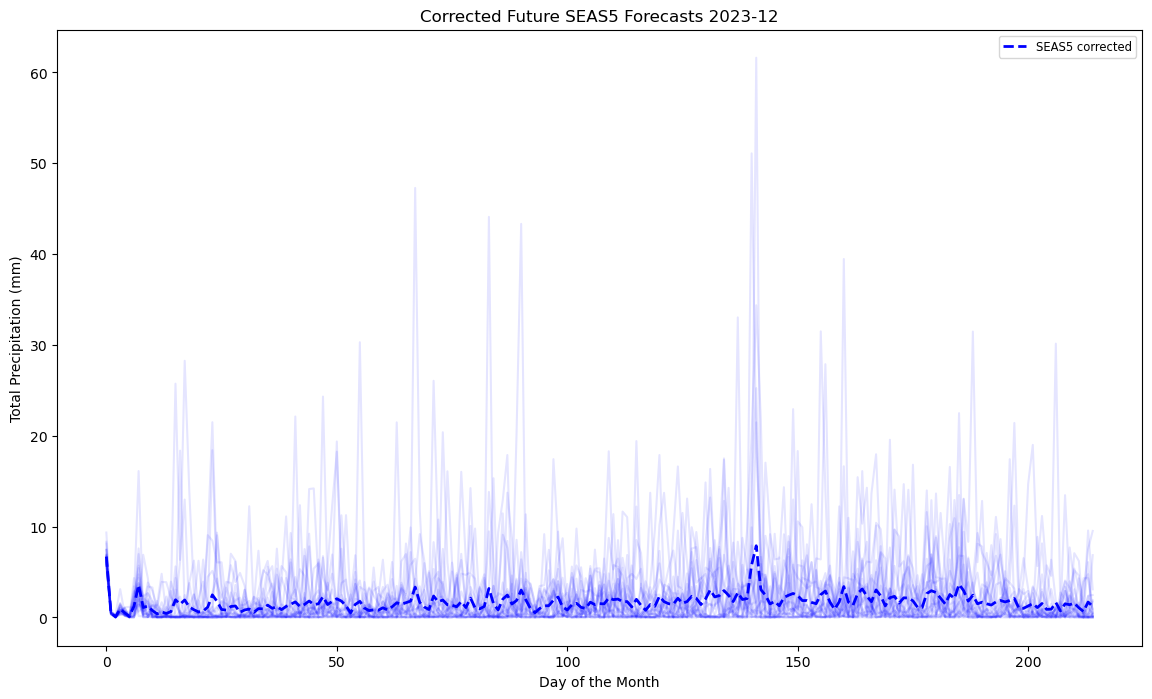

In [100]:
# Create a plot
plt.figure(figsize=(14, 8))

# Plot corrected SEAS5 data for each member
for member in range(seas5_t.shape[0]):
    plt.plot(seas5_corrected[variable][member].values, color="blue", alpha=0.1) #label=f"Corrected SEAS5 Member {member+1}",

# Plot ERA5 data  (Add ERA5 data for 2024 when available)
#plt.plot(era5_da.sel(month=month, year=year), label="ERA5 Observations", color="black", linestyle="--", linewidth=2)

# Plot corrected SEAS5 data for ensemble member
plt.plot(seas5_bc_ensmean[variable], label="SEAS5 corrected", color="blue", linestyle="--", linewidth=2)

# Adding labels and title
plt.xlabel("Day of the Month")
plt.ylabel("Total Precipitation (mm)")
plt.title(f"Corrected Future SEAS5 Forecasts {year}-{month:02d}")
plt.legend(loc="best", fontsize="small", ncol=1)

# Show the plot
plt.show()